In [128]:
import numpy as np
import matplotlib.pyplot as plt

In [129]:
# parameters
task = "auditory"
n_concat = 3
n_components_pca = 10
n_subjects_subgroup = 50

In [130]:
# load data
results_dir = "/storage/store2/work/aheurteb/mvicad/tbme/results/results_camcan/mvica/clean_subjects/"
W_save_name = f"W_{task}_task_{n_subjects_subgroup}_{n_components_pca}_{n_concat}.npy"
S_save_name = f"S_{task}_task_{n_subjects_subgroup}_{n_components_pca}_{n_concat}.npy"
W_mvica = np.load(results_dir + W_save_name)
S_mvica = np.load(results_dir + S_save_name)

In [131]:
# correct scale and sign
scale = np.linalg.norm(S_mvica, axis=1)  # shape (p,)
sign = 2 * ((np.max(S_mvica, axis=1) + np.min(S_mvica, axis=1) > 0) - 0.5)   # shape (p,)
scale_and_sign = (scale * sign)[:, None]  # shape (p, 1)
S_mvica_2 = S_mvica / scale_and_sign
W_mvica_2 = np.array([W / scale_and_sign for W in W_mvica])

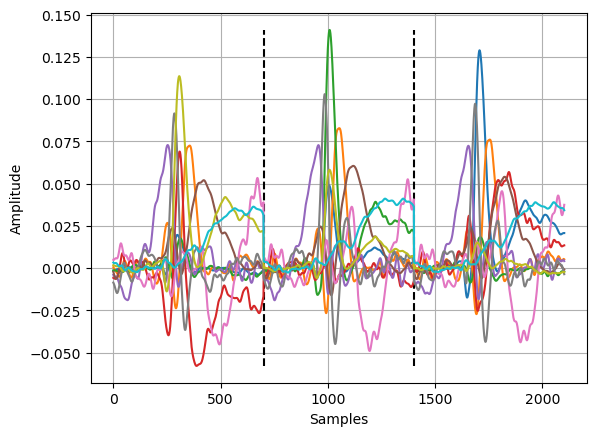

In [132]:
# plot sources
if n_concat == 1:
    plt.plot(np.linspace(-0.2, 0.5, 701), S_mvica_2.T)
    plt.vlines(
        x=0, ymin=np.min(S_mvica_2), ymax=np.max(S_mvica_2), colors="grey",
        linestyles="--")
    plt.xlabel("Time (s)")
else:
    plt.plot(S_mvica_2.T)
    for i in range(1, n_concat):
        plt.vlines(
            x=i*701, ymin=np.min(S_mvica_2), ymax=np.max(S_mvica_2), colors="black",
            linestyles="--")
    plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

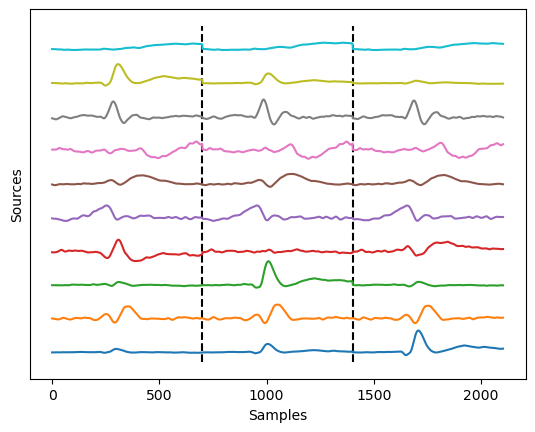

In [133]:
# sources one by one
height = 0.2
if n_concat == 1:
    for i in range(n_components_pca):
        plt.plot(np.linspace(-0.2, 0.5, 701), S_mvica_2[i] + i * height)
    plt.vlines(
        x=0, ymin=np.min(S_mvica_2), ymax=height*(n_components_pca-1)+np.max(S_mvica_2),
        colors="grey", linestyles="--")
    plt.xlabel("Time (s)")
else:
    for i in range(n_components_pca):
        plt.plot(S_mvica_2[i] + i * height)
    for i in range(1, n_concat):
        plt.vlines(
            x=i*701, ymin=np.min(S_mvica_2), ymax=height*(n_components_pca-1)+np.max(S_mvica_2),
            colors="black", linestyles="--")
    plt.xlabel("Samples")
plt.yticks([])
plt.ylabel("Sources")
plt.show()

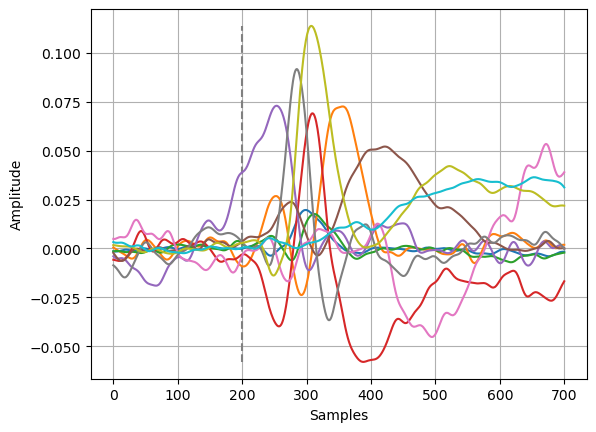

In [134]:
# plot one concatenation
concat_id = 0
plt.plot(S_mvica_2[:, concat_id*701:(concat_id+1)*701].T)
plt.vlines(
    x=200, ymin=np.min(S_mvica_2[:, concat_id*701:(concat_id+1)*701]),
    ymax=np.max(S_mvica_2[:, concat_id*701:(concat_id+1)*701]), colors="grey",
    linestyles="--")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()

Ideas: increase nb of concats, sources, or subjects. Hopefully, sources will be consistent across concatenations. 

A possibility would be to launch MVICAD^2 with only 3 or 4 sources but many subjects. 

# look at PCA data

In [135]:
import os
from multiviewica_delay.multiviewica_shifts._reduce_data import pca_reduce_data

In [136]:
def load_data(task, n_subjects, n_concat):
    data_dir = f"/storage/store2/work/aheurteb/mvicad/tbme/data/camcan/{task}/clean_subjects/"
    suffix1 = f"_{task}_task_mag_{n_subjects}_{n_concat}.npy"
    suffix2 = f"_{task}_task_{n_subjects}_{n_concat}.npy"
    # Load dataset
    dataset_name = "X" + suffix1
    dataset_path = data_dir + dataset_name
    print(f"dataset path : {dataset_path}")
    if os.path.exists(dataset_path):
        X = np.load(dataset_path)
    else:
        raise NameError("Dataset not found.")
    # Save subjects
    subjects_name = "subjects" + suffix2
    subjects_path = data_dir + subjects_name
    if os.path.exists(subjects_path):
        subjects = np.load(subjects_path)
    else:
        raise NameError("Subjects not found.")
    # save ages
    ages_name = "ages" + suffix2
    ages_path = data_dir + ages_name
    if os.path.exists(ages_path):
        ages = np.load(ages_path)
    else:
        raise NameError("Ages not found.")
    return X, subjects, ages


def reduce_nb_subjects(
    X, subjects, ages, n_subjects_subgroup=None, random_state=None,
):
    n_subjects_data = len(X)
    # eventually reduce the number of subjects
    if n_subjects_subgroup is not None:
        assert n_subjects_subgroup <= n_subjects_data
        rng = np.random.RandomState(random_state)
        indices = rng.choice(
            np.arange(n_subjects_data), size=n_subjects_subgroup, replace=False)
        X = X[indices]
        subjects = subjects[indices]
        ages = ages[indices]
    return X, subjects, ages


def load_and_reduce_data(
    task, n_concat, n_components_pca, n_subjects_subgroup=None, random_state=None,
):
    # define n_subjects_data
    if task == "visual":
        n_subjects_data = 477
    elif task == "auditory":
        n_subjects_data = 160  # 501
    # load data
    X, subjects, ages = load_data(
        task=task, n_subjects=n_subjects_data, n_concat=n_concat)
    print(f"Dataset shape : {X.shape}")
    # reduce the number of subjects
    X, subjects, ages = reduce_nb_subjects(
        X, subjects, ages, n_subjects_subgroup=n_subjects_subgroup,
        random_state=random_state)
    print(f"Dataset shape after reducing the number of subjects : {X.shape}")
    # PCA
    P, X = pca_reduce_data(
        X, n_components=n_components_pca, random_state=random_state)
    print(f"Dataset shape after PCA : {X.shape}")
    return X, subjects, ages, n_subjects_data


In [137]:
# load and reduce data
random_state = 42
X, subjects, ages, n_subjects_data = load_and_reduce_data(
    task, n_concat, n_components_pca, n_subjects_subgroup, random_state)

dataset path : /storage/store2/work/aheurteb/mvicad/tbme/data/camcan/auditory/clean_subjects/X_auditory_task_mag_160_3.npy
Dataset shape : (160, 102, 2103)
Dataset shape after reducing the number of subjects : (50, 102, 2103)
Dataset shape after PCA : (50, 10, 2103)


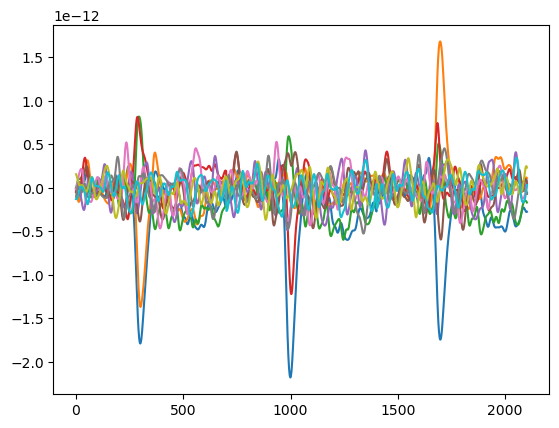

In [138]:
plt.plot(X[8].T);

# sources importance

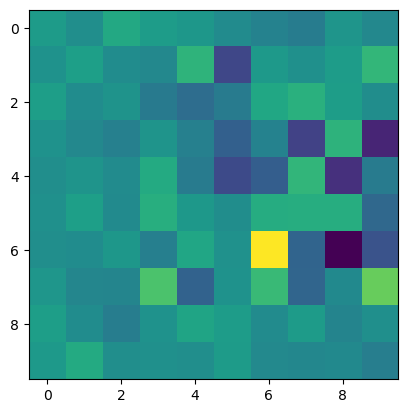

In [139]:
plt.imshow(W_mvica_2[0]);

In [140]:
norms = np.mean([np.linalg.norm(W, axis=1) for W in W_mvica_2], axis=0)
order = np.argsort(norms)[::-1]

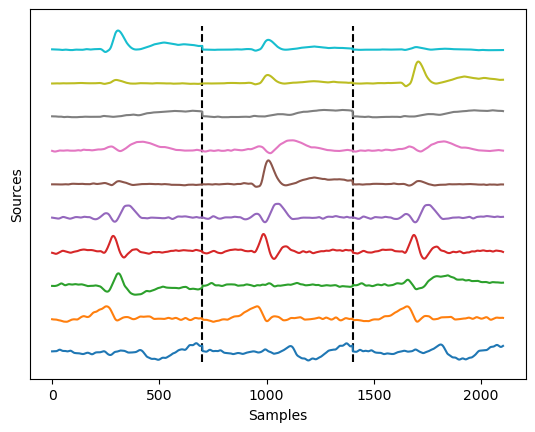

In [141]:
# sources one by one
height = 0.2
if n_concat == 1:
    for i in range(n_components_pca):
        plt.plot(np.linspace(-0.2, 0.5, 701), S_mvica_2[i] + i * height)
    plt.vlines(
        x=0, ymin=np.min(S_mvica_2), ymax=height*(n_components_pca-1)+np.max(S_mvica_2),
        colors="grey", linestyles="--")
    plt.xlabel("Time (s)")
else:
    for i in range(n_components_pca):
        plt.plot(S_mvica_2[order[i]] + i * height)
    for i in range(1, n_concat):
        plt.vlines(
            x=i*701, ymin=np.min(S_mvica_2), ymax=height*(n_components_pca-1)+np.max(S_mvica_2),
            colors="black", linestyles="--")
    plt.xlabel("Samples")
plt.yticks([])
plt.ylabel("Sources")
plt.show()

Idea: if a line of W has a higher norm, then its corresponding source should be more important to the reconstruction.